In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.models import Model
import keras.utils as image
import tensorflow as tf
from tensorflow.keras.models import save_model
import cv2 
from sklearn.model_selection import train_test_split
#from tensorflow.python.framework import ops
import tensorflow.keras.layers as L
#import tensorflow.compat.v1.keras.backend as K
import matplotlib.pyplot as plt
#import keras_utils

In [2]:
!unzip /content/dataset.zip

Archive:  /content/dataset.zip
 extracting: dataset/1.png           
 extracting: dataset/10.png          
 extracting: dataset/100.png         
 extracting: dataset/101.png         
 extracting: dataset/102.png         
 extracting: dataset/103.png         
 extracting: dataset/104.png         
  inflating: dataset/105.png         
 extracting: dataset/106.png         
 extracting: dataset/107.png         
 extracting: dataset/108.png         
 extracting: dataset/109.png         
 extracting: dataset/11.png          
 extracting: dataset/110.png         
 extracting: dataset/111.png         
 extracting: dataset/112.png         
 extracting: dataset/113.png         
 extracting: dataset/114.png         
 extracting: dataset/115.png         
 extracting: dataset/116.png         
 extracting: dataset/117.png         
 extracting: dataset/118.png         
 extracting: dataset/119.png         
 extracting: dataset/12.png          
 extracting: dataset/120.png         
 extracting: datase

#2-Load Data

In [3]:
path= "../content/dataset/"


In [4]:
from pathlib import Path

data = []
for filename in os.listdir(path):
    if filename.endswith(".png"):
        img = image.load_img(path + filename, target_size=(300, 300))
        data.append(image.img_to_array(img))
data = np.array(data)



In [5]:
def show_pics_data(X, n=10, title=""):
    plt.figure(figsize=(15, 4))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(image.array_to_img(X[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title, fontsize = 20)

def show_data(X, n=10, height=28, width=28, title=""):
    plt.figure(figsize=(10, 3))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(X[i].reshape((height,width)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title, fontsize = 20)

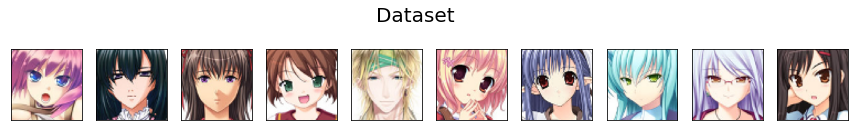

In [8]:
show_pics_data(data, title="Dataset")

#3- Preprocess 

Noise

In [6]:
# adds the gaussian noise based on the mean and the standard deviation 
def add_gaussian_noise(data):
  mean = (10, 10, 10)
  std = (50, 50, 50)
  row, col, channel = data.shape
  noise = np.random.normal(mean, std, (row, col, channel)).astype('uint8')
  return data + noise


def add_gaussian_to_dataset(data):
    count = 0
    end = len(data)
    output_data = []
    while count < end:
        output_data.append(add_gaussian_noise(data[count]))
        count+=1
    return np.array(output_data)

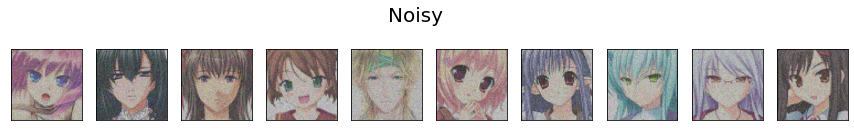

In [10]:
show_pics_data(add_gaussian_to_dataset(data), title="Noisy")

In [ ]:
tf.keras.backend.clear_session()

In [7]:
train_data = data[:500]
test_data = data[512:612]

In [8]:
gaussian_train_data = add_gaussian_to_dataset(train_data)
gaussian_test_data = add_gaussian_to_dataset(test_data)

In [9]:
train_data = train_data / 255.0
test_data = test_data / 255.0
# reduce images
gaussian_train_data = gaussian_train_data / 255.0 
gaussian_test_data = gaussian_test_data / 255.0 

print(gaussian_train_data.shape)
print(gaussian_test_data.shape)

(500, 300, 300, 3)
(100, 300, 300, 3)


#4- Construct the autoencoder model

In [10]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Conv2D, UpSampling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [11]:
def create_model():
  x = Input(shape=(300, 300, 3)) 

  # Encoder
  e_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  pool1 = MaxPooling2D((2, 2), padding='same')(e_conv1)
  batchnorm_1 = BatchNormalization()(pool1)
  e_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(batchnorm_1)
  pool2 = MaxPooling2D((2, 2), padding='same')(e_conv2)
  batchnorm_2 = BatchNormalization()(pool2)
  e_conv3 = Conv2D(16, (3, 3), activation='relu', padding='same')(batchnorm_2)
  h = MaxPooling2D((2, 2), padding='same')(e_conv3)


  # Decoder
  d_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
  up1 = UpSampling2D((2, 2))(d_conv1)
  d_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
  up2 = UpSampling2D((2, 2))(d_conv2)
  d_conv3 = Conv2D(16, (3, 3), activation='relu')(up2)
  up3 = UpSampling2D((2, 2))(d_conv3)
  r = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3)

  model = Model(x, r)
  model.compile(optimizer='adam', loss='mse')
  return model

In [12]:
gaussian_auto_encoder = create_model()
gaussian_early_stop = EarlyStopping(monitor='loss', patience=3)
gaussian_history = gaussian_auto_encoder.fit(gaussian_train_data, train_data, epochs=15, batch_size=32, callbacks=[gaussian_early_stop])

Epoch 1/15
16/16 [==============================] - 16s 280ms/step - loss: 0.0454
Epoch 2/15
16/16 [==============================] - 3s 187ms/step - loss: 0.0201
Epoch 3/15
16/16 [==============================] - 3s 188ms/step - loss: 0.0153
Epoch 4/15
16/16 [==============================] - 3s 187ms/step - loss: 0.0149
Epoch 5/15
16/16 [==============================] - 3s 189ms/step - loss: 0.0139
Epoch 6/15
16/16 [==============================] - 3s 186ms/step - loss: 0.0129
Epoch 7/15
16/16 [==============================] - 3s 188ms/step - loss: 0.0116
Epoch 8/15
16/16 [==============================] - 3s 188ms/step - loss: 0.0111
Epoch 9/15
16/16 [==============================] - 3s 191ms/step - loss: 0.0112
Epoch 10/15
16/16 [==============================] - 3s 190ms/step - loss: 0.0105
Epoch 11/15
16/16 [==============================] - 3s 190ms/step - loss: 0.0106
Epoch 12/15
16/16 [==============================] - 3s 191ms/step - loss: 0.0107
Epoch 13/15
16/16 [=====

In [18]:
 gaussian_auto_encoder.save('Mymodel_1.h5')
 #files.download('Mymodel_1.h5')

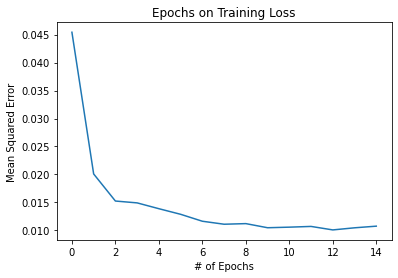

In [19]:
plt.plot(gaussian_history.epoch, gaussian_history.history['loss'])
plt.title('Epochs on Training Loss')
plt.xlabel('# of Epochs')
plt.ylabel('Mean Squared Error')
plt.show()

In [20]:
result = gaussian_auto_encoder.predict(gaussian_test_data)
gaussian_auto_encoder.evaluate(test_data, gaussian_test_data)

4/4 [==============================] - 1s 48ms/step - loss: 0.4958


0.49577388167381287

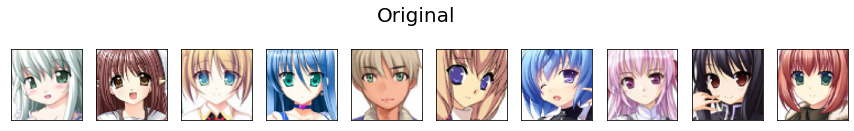

In [21]:
show_pics_data(test_data, title="Original")

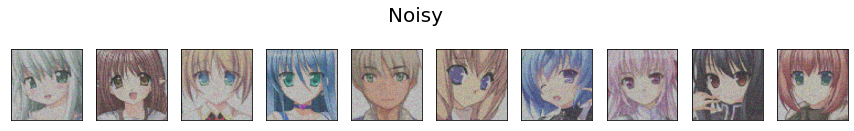

In [22]:
show_pics_data(gaussian_test_data, title="Noisy")

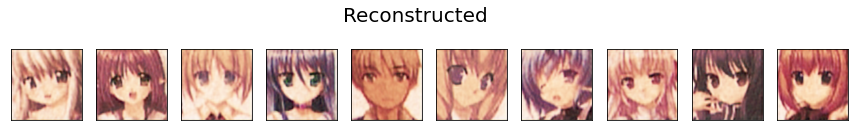

In [23]:
show_pics_data(result, title="Reconstructed")

In [25]:
test_path="../content/custom/"
custom = []
for filename in os.listdir(test_path):
    if filename.endswith(".jpeg"):
        img = image.load_img(test_path + filename, target_size=(300, 300))
        custom.append(image.img_to_array(img))
custom = np.array(custom)

In [26]:
def show_custom_data(X, n=3, title=""):
    plt.figure(figsize=(15, 4))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(image.array_to_img(X[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title, fontsize = 20)

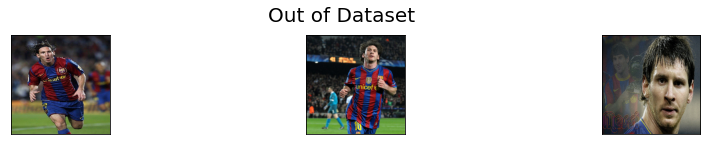

In [27]:
show_custom_data(custom, title="Out of Dataset")

In [28]:
cutom_gaussian_test_data = add_gaussian_to_dataset(custom)

In [29]:
cutom_gaussian_test_data = cutom_gaussian_test_data / 255.0 

In [30]:
from keras.models import load_model
test_model = load_model('Mymodel_1.h5')

In [31]:
test_model.compile(optimizer='adam', loss='mse')

In [32]:
test_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0     

In [33]:
result = test_model.predict(cutom_gaussian_test_data)

1/1 [==============================] - 0s 409ms/step


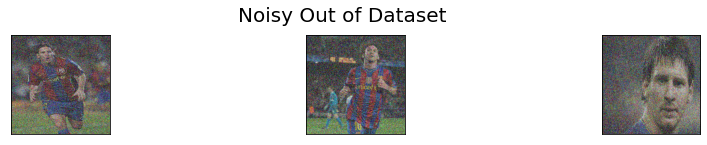

In [34]:
show_custom_data(cutom_gaussian_test_data, title="Noisy Out of Dataset")

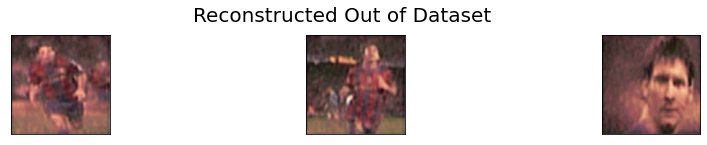

In [35]:
show_custom_data(result, title="Reconstructed Out of Dataset")